<div>
<img src="https://www.nasa.gov/wp-content/uploads/2024/07/osdr-gl4hs-logo.png" width="600"/>
</div>

# **NOTEBOOK 6: Performing differential gene expression analysis**
In this notebook, you will run statistical tests to determine which genes are differentially expressed between ground control and space flight groups.

## **Objectives of this notebook**
The primary objective of this notebook is to perform [differential gene expression analysis](https://www.youtube.com/watch?v=tlf6wYJrwKY) (DGEA) using [Python's implementation of DESeq2](https://pydeseq2.readthedocs.io/en/stable/auto_examples/plot_step_by_step.html#sphx-glr-auto-examples-plot-step-by-step-py) to find genes which have a large enough [log2 fold change](https://www.biostars.org/p/9505003/) between ground control and space flight as well as a low enough adjusted [p-value](https://www.youtube.com/watch?v=vemZtEM63GY) as to be statistically significant.

DGEA is actually a series of several [statistical hypothesis tests](https://www.youtube.com/watch?v=0oc49DyA3hU) - one per gene. The null hypothesis is that there is no significant difference between the expression of that gene between ground control and spaceflight groups. The alternate hypothesis is that there is a significant difference between the expression of that gene between those 2 groups. This difference can either be over-regulated gene expression or under-regulated gene expression, making this a [two-tailed test](https://www.youtube.com/watch?v=bsZGt-caXO4).

Additionally, you will use principal components analysis (PCA) to visualize the gene expression of all the samples in OSD-104 to determine if the samples separate according to their condition (space flight and ground control). You can learn more about PCA [here](https://youtu.be/HMOI_lkzW08?si=zTSi-OclCvmEvdVR). After performing DGEA, you will create a volcano plot of the p-values to visualize their distribution. You can learn more about volcano plots [here](https://www.youtube.com/watch?v=7aWAdw2jhj0).

We will no longer use the FASTQ data from the previous notebooks regarding the single sample paired end reads. Instead, we will download the GeneLab-processed count data for all the samples in OSD-104 and use that as our starting point for this and the next notebook.

## **UNIX commands introduced in this notebook**

[`unzip`](https://linux.die.net/man/1/unzip) command to extract the files in a ZIP archive.

# Prepare runtime environment for lab

In [45]:
# mount google drive to mnt mount point
from google.colab import drive
drive.flush_and_unmount()
drive.mount("mnt")


Mounted at mnt


In [46]:
# time the notebook
import datetime
start_time = datetime.datetime.now()
print('notebook start time: ', start_time.strftime('%Y-%m-%d %H:%M:%S'))

notebook start time:  2025-07-16 04:21:23


In [47]:
# define OSD dataset number to use for this notebook

OSD_DATASET='104'
GLDS_DATASET='104'

#OSD_DATASET='511'
#GLDS_DATASET='511'

#OSD_DATASET='580'
#GLDS_DATASET='573'

In [48]:
# define the threshold for coefficient of variation
CV_THRESH=0.5

In [49]:
# create META_DIR directory for metadata
import os
META_DIR="/content/mnt/MyDrive/NASA/GL4HS/META/" + OSD_DATASET
if not os.path.exists(META_DIR):
  !mkdir -p {META_DIR}

In [50]:
# create DGEA_DIR directory for DGEA output
DGEA_DIR="/content/mnt/MyDrive/NASA/GL4HS/DGEA/" + OSD_DATASET
if not os.path.exists(DGEA_DIR):
  !mkdir -p {DGEA_DIR}

In [51]:
# install packages and import the modules needed to do DGEA
!pip install pyDeseq2 > /dev/null
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import numpy as np
!pip install scikit-learn > /dev/null
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
!pip install Ensembl_converter > /dev/null
from Ensembl_converter import EnsemblConverter

In [52]:
# define log2 fold change threshold
LOG2FC_THRESH = 2

# Define Python methods for notebook

In [53]:
# define method for removing NaNs from dataframe
def drop_nans(df):
  # drop NaN rows
  df = df.dropna(inplace=False)
  return df

You can learn more about Python NaN [here](https://stackoverflow.com/questions/17628613/what-is-inf-and-nan).

In [54]:
# define method for dropping low-count genes
def drop_lowcount(df, threshold=10):

  # let's drop any low-count genes
  if 'transcript' in df.columns:
    df = df[df.drop(columns=['transcript']).sum(axis=1) >= threshold]
  elif 'Unnamed: 0' in df.columns:
    df = df[df.drop(columns=['Unnamed: 0']).sum(axis=1) >= threshold]
  else:
    raise Exception("check file format")
  return df


You can read more about low-count gene thresholds [here](https://www.biostars.org/p/251922/).

In [55]:
# define method for filtering low coefficient-of-variation genes
def filter_cvs(df, thresh):
  import numpy as np
  import matplotlib.pyplot as plt

  # calculate coefficient of variation
  cvs=list()
  for i in range(len(df)):
    m = np.mean(df.iloc[i][1:])
    sd = np.std(df.iloc[i][1:])
    cvs.append(sd/m)

  # plot hist of dist of coev of variation
  fig, axs = plt.subplots()
  axs.hist(cvs, bins=20)

  # add labels for x and y axes
  plt.xlabel('coefficient of variation')
  plt.ylabel('number of genes')

  # keep genes with cv > thresh
  indices = list()
  for i in range(len(cvs)):
    if cvs[i] > thresh:
      indices.append(i)
  return df.iloc[indices]


You can read more about the coefficient of variation [here](https://en.wikipedia.org/wiki/Coefficient_of_variation).

In [56]:
# define method to transpose a dataframe
def transpose_df(df, cur_index_col, new_index_col):
  df = df.set_index(cur_index_col).T
  df.reset_index(level=0, inplace=True)
  cols = [new_index_col] + list(df.columns)[1:]
  df.columns = cols
  return df

You can read more about transposition [here](https://www.geeksforgeeks.org/python-pandas-dataframe-transpose/).

In [57]:
# define method for dropping ERCC genes from dataframe
def drop_ercc(df):
  df = df[df['Unnamed: 0'].str.contains('ERCC-') == False]
  return df

You can read more about ERCC [here](https://www.nist.gov/programs-projects/external-rna-controls-consortium).

In [58]:
# define method for running PCA
def run_pca(_expr, _meta):
  # first only keep "Ground Control" and "Space Flight" samples
  gc_samples = list(_meta[_meta['Factor Value[Spaceflight]'] == 'ground control']['Sample Name'])
  sf_samples = list(_meta[_meta['Factor Value[Spaceflight]'] == 'space flight']['Sample Name'])
  samples = gc_samples + sf_samples
  expr = _expr[_expr['sample'].isin(samples)]
  X = np.array(expr.drop(columns=['sample']))
  print('X shape: ', X.shape)
  factor_list = list()
  for sample in list(expr['sample']):
      factor_value = _meta[_meta['Sample Name'] == sample]['Factor Value[Spaceflight]'].values[0]
      factor_list.append(factor_value)
  y = np.array(list(factor_list))
  print('y shape: ', y.shape)
  target_names=np.array(['ground control', 'space flight'])

  # run PCA to reduce dimensions from 23,419 to 2!
  pca = PCA(n_components=2)
  X_r = pca.fit_transform(X)

  # Percentage of variance explained for each components
  print(
      "explained variance ratio (first two components): %s"
      % str(pca.explained_variance_ratio_)
  )

  # plot the pca plot
  plt.figure()
  colors = ["navy", "turquoise"]
  lw = 2
  for color, i, target_name in zip(colors, ['ground control', 'space flight'], target_names):
      plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name)
  plt.legend(loc="best", shadow=False, scatterpoints=1)
  plt.title("PCA of OSD dataset")

  # show the last digits of the sample name if the number of samples is less than 40
  if len(expr) < 40:
    samples = list(expr['sample'])
    for i, txt in enumerate(samples):
        plt.annotate(txt[-16:], (X_r[i][0], X_r[i][1]))
  plt.show()


In [59]:
# define method to convert ensembl gene id's to gene symbols
def get_symbol_from_id(gene_id_list):
  # Create an instance of EnsemblConverter
  converter = EnsemblConverter()

  # Convert Ensembl IDs to gene symbols
  result = converter.convert_ids(gene_id_list)

  # Print the resulting DataFrame
  gene_symbol_list = list()
  for i in range(len(result)):
    gene_symbol_list.append(result.iloc[i]['Symbol'])

  return gene_symbol_list

# Download data from OSDR

In [60]:
# open the URL printed below in another browser window
url = !echo https://visualization.osdr.nasa.gov/biodata/api/v2/dataset/OSD-{OSD_DATASET}/files/\?format=browser
print(url[0])

https://visualization.osdr.nasa.gov/biodata/api/v2/dataset/OSD-104/files/?format=browser


In [61]:
# download OSD unnormalized count data
import pandas as pd
url = 'https://osdr.nasa.gov/geode-py/ws/studies/OSD-' + OSD_DATASET + '/download?source=datamanager&file=GLDS-' + GLDS_DATASET + '_rna_seq_Unnormalized_Counts.csv'
# url = 'https://osdr.nasa.gov/geode-py/ws/studies/OSD-' + OSD_DATASET + '/download?source=datamanager&file=GLDS-' + GLDS_DATASET + '_rna_seq_STAR_Unnormalized_Counts.csv'
expr_df = pd.read_csv(url)
expr_df.head()

,Unnamed: 0,Mmus_C57-6J_SLS_FLT_Rep1_M23,Mmus_C57-6J_SLS_FLT_Rep2_M24,Mmus_C57-6J_SLS_FLT_Rep3_M25,Mmus_C57-6J_SLS_FLT_Rep4_M26,Mmus_C57-6J_SLS_FLT_Rep5_M27,Mmus_C57-6J_SLS_FLT_Rep6_M28,Mmus_C57-6J_SLS_GC_Rep1_M33,Mmus_C57-6J_SLS_GC_Rep2_M34,Mmus_C57-6J_SLS_GC_Rep3_M35,Mmus_C57-6J_SLS_GC_Rep4_M36,Mmus_C57-6J_SLS_GC_Rep5_M37,Mmus_C57-6J_SLS_GC_Rep6_M38
0,ENSMUSG00000000001,869.0,706.0,835.0,871.0,1069.0,700.0,1205.0,908.0,1078.0,877.0,884.0,911.0
1,ENSMUSG00000000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ENSMUSG00000000028,91.0,121.0,87.0,139.0,193.0,104.0,145.0,117.0,135.0,114.0,128.0,130.0
3,ENSMUSG00000000031,68226.0,64898.0,85595.0,90775.0,71300.0,56376.0,143726.0,104717.0,128088.0,115071.0,108243.0,118878.0
4,ENSMUSG00000000037,7.0,8.0,9.0,11.0,11.0,5.0,21.0,10.0,10.0,5.0,3.0,16.0


In [62]:
# identify the shape of the expr_df dataframe
expr_df.shape

(55536, 13)

In [63]:
# call drop_ercc
# there may or may not be ERCC records to drop
expr_df = drop_ercc(expr_df)
expr_df.shape

(55536, 13)

In [64]:
# call drop_nans
# there may or may not be NaNs to drop
expr_df = drop_nans(expr_df)
expr_df.shape

(55536, 13)

In [65]:
# call drop_lowcount with threshold=50
expr_df = drop_lowcount(expr_df, threshold=50)
expr_df.shape

(17690, 13)

(2104, 13)

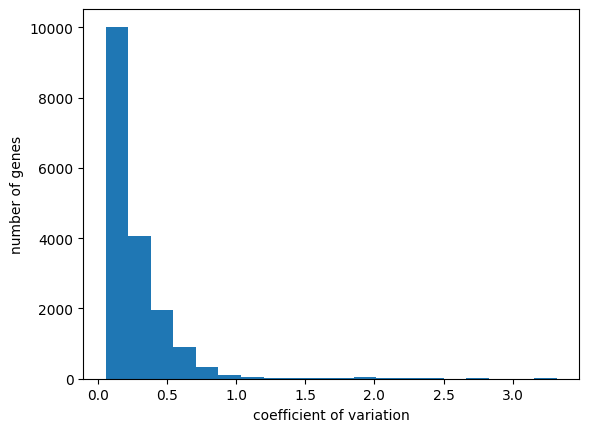

In [66]:
# call filter_cvs with thresh=CV_THRESH
expr_df = filter_cvs(expr_df, thresh=CV_THRESH)
expr_df.shape

In [67]:
# first save expr_df to file in gdrive for use in next notebook
expr_df.to_csv(DGEA_DIR + '/expr_df.csv', sep=',', index=None)

In [68]:
# then transpose expr_df to be samples x genes
expr_df = transpose_df(expr_df, 'Unnamed: 0', 'sample')
expr_df.head()

,sample,ENSMUSG00000000049,ENSMUSG00000000167,ENSMUSG00000000204,ENSMUSG00000000214,ENSMUSG00000000247,ENSMUSG00000000303,ENSMUSG00000000308,ENSMUSG00000000385,ENSMUSG00000000386,...,ENSMUSG00000118101,ENSMUSG00000118132,ENSMUSG00000118161,ENSMUSG00000118206,ENSMUSG00000118229,ENSMUSG00000118232,ENSMUSG00000118249,ENSMUSG00000118292,ENSMUSG00000118317,ENSMUSG00000118353
0,Mmus_C57-6J_SLS_FLT_Rep1_M23,11.0,15.0,0.0,6.0,7.0,64.0,8.0,36.0,6.0,...,1.0,1.0,7.62,9.0,3.0,5.0,3.0,26.0,7.0,2.84
1,Mmus_C57-6J_SLS_FLT_Rep2_M24,11.0,3.0,3.0,37.0,12.0,113.0,13.0,3.0,4.0,...,1.0,3.0,0.00,7.0,0.0,0.0,11.0,26.0,6.0,1.37
2,Mmus_C57-6J_SLS_FLT_Rep3_M25,23.0,5.0,4.0,16.0,10.0,77.0,13.0,12.0,4.0,...,7.0,10.0,4.23,1.0,7.0,5.0,8.0,28.0,13.0,5.11
3,Mmus_C57-6J_SLS_FLT_Rep4_M26,18.0,3.0,8.0,12.0,20.0,76.0,7.0,15.0,9.0,...,12.0,5.0,3.58,4.0,2.0,5.0,12.0,19.0,8.0,5.11
4,Mmus_C57-6J_SLS_FLT_Rep5_M27,66.0,5.0,18.0,16.0,12.0,33.0,2.0,11.0,16.0,...,7.0,5.0,2.09,13.0,22.0,6.0,6.0,17.0,15.0,6.15


In [69]:
# determine the shape of the expr_df_T dataframe
expr_df.shape

(12, 2105)

In [70]:
# read in  metadata
url = 'https://osdr.nasa.gov/geode-py/ws/studies/OSD-' + OSD_DATASET + \
  '/download\?source=datamanager\&file=OSD-' + OSD_DATASET + '_metadata_OSD-' + GLDS_DATASET + '-ISA.zip'
  # '/download\?source=datamanager\&file=OSD-' + OSD_DATASET + '_metadata_GLDS-' + GLDS_DATASET + '-ISA.zip'

!curl -L {url} -o {META_DIR}/metadata-{OSD_DATASET}.zip
!unzip -o {META_DIR}/metadata-{OSD_DATASET}.zip -d {META_DIR}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3758  100  3758    0     0   5095      0 --:--:-- --:--:-- --:--:--  5099
100 67922  100 67922    0     0  49561      0  0:00:01  0:00:01 --:--:--  110k
Archive:  /content/mnt/MyDrive/NASA/GL4HS/META/104/metadata-104.zip
 extracting: /content/mnt/MyDrive/NASA/GL4HS/META/104/s_OSD-104.txt  
 extracting: /content/mnt/MyDrive/NASA/GL4HS/META/104/a_OSD-104_transcription-profiling_rna-sequencing-(rna-seq)_illumina.txt  
 extracting: /content/mnt/MyDrive/NASA/GL4HS/META/104/a_OSD-104_dna-methylation-profiling_nucleotide-sequencing_illumina.txt  
 extracting: /content/mnt/MyDrive/NASA/GL4HS/META/104/i_Investigation.txt  


In [71]:
# check metadata
meta_df = pd.read_csv(f"{META_DIR}/s_OSD-" + OSD_DATASET + ".txt", sep='\t')
meta_df.head()

,Source Name,Sample Name,Characteristics[Organism],Term Source REF,Term Accession Number,Characteristics[Strain],Term Source REF.1,Term Accession Number.1,Characteristics[Animal Source],Characteristics[Sex],...,Unit.4,Term Source REF.13,Term Accession Number.13,Parameter Value[absorbed radiation dose rate],Unit.5,Term Source REF.14,Term Accession Number.14,Parameter Value[ionizing radiation categorized by source],Term Source REF.15,Term Accession Number.15
0,RR1_GC_M33,Mmus_C57-6J_SLS_GC_Rep1_M33,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,C57BL/6J,EFO,http://www.ebi.ac.uk/efo/EFO_0000606,Jackson Laboratory,Female,...,Not Applicable,OSD,https://osdr.nasa.gov/,NaN,Not Applicable,OSD,https://osdr.nasa.gov/,Not Applicable,NCIT,http://purl.obolibrary.org/obo/NCIT_C48660
1,RR1_GC_M34,Mmus_C57-6J_SLS_GC_Rep2_M34,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,C57BL/6J,EFO,http://www.ebi.ac.uk/efo/EFO_0000606,Jackson Laboratory,Female,...,Not Applicable,OSD,https://osdr.nasa.gov/,NaN,Not Applicable,OSD,https://osdr.nasa.gov/,Not Applicable,NCIT,http://purl.obolibrary.org/obo/NCIT_C48660
2,RR1_GC_M35,Mmus_C57-6J_SLS_GC_Rep3_M35,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,C57BL/6J,EFO,http://www.ebi.ac.uk/efo/EFO_0000606,Jackson Laboratory,Female,...,Not Applicable,OSD,https://osdr.nasa.gov/,NaN,Not Applicable,OSD,https://osdr.nasa.gov/,Not Applicable,NCIT,http://purl.obolibrary.org/obo/NCIT_C48660
3,RR1_GC_M36,Mmus_C57-6J_SLS_GC_Rep4_M36,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,C57BL/6J,EFO,http://www.ebi.ac.uk/efo/EFO_0000606,Jackson Laboratory,Female,...,Not Applicable,OSD,https://osdr.nasa.gov/,NaN,Not Applicable,OSD,https://osdr.nasa.gov/,Not Applicable,NCIT,http://purl.obolibrary.org/obo/NCIT_C48660
4,RR1_GC_M37,Mmus_C57-6J_SLS_GC_Rep5_M37,Mus musculus,NCBITAXON,http://purl.bioontology.org/ontology/NCBITAXON...,C57BL/6J,EFO,http://www.ebi.ac.uk/efo/EFO_0000606,Jackson Laboratory,Female,...,Not Applicable,OSD,https://osdr.nasa.gov/,NaN,Not Applicable,OSD,https://osdr.nasa.gov/,Not Applicable,NCIT,http://purl.obolibrary.org/obo/NCIT_C48660


In [72]:
# change Factor Value[Spaceflight] to lower case
for i in range(len(meta_df)):
  meta_df.loc[i, 'Factor Value[Spaceflight]'] = meta_df.iloc[i]['Factor Value[Spaceflight]'].lower().strip()

In [73]:
# see how many samples are flight and how many are ground
meta_df['Factor Value[Spaceflight]'].value_counts()

,count
Factor Value[Spaceflight],
ground control,6
space flight,6


In [74]:
# drop all values from expr_df and meta_df that are not either "Ground Control" or "Space Flight"
gc_samples = list(meta_df[meta_df['Factor Value[Spaceflight]'] == 'ground control']['Sample Name'])
sf_samples = list(meta_df[meta_df['Factor Value[Spaceflight]'] == 'space flight']['Sample Name'])
samples = gc_samples + sf_samples
expr_df = expr_df[expr_df['sample'].isin(samples)]
meta_df = meta_df[meta_df['Sample Name'].isin(samples)]

In [75]:
# check shape of final dataframes prior to analysis
print('expr shape: ', expr_df.shape)
print('meta shape: ', meta_df.shape)

expr shape:  (12, 2105)
meta shape:  (12, 71)


# Run PCA

Here we run principal components analysis (PCA) to determine if the samples separate in the plane.

X shape:  (12, 2104)
y shape:  (12,)
explained variance ratio (first two components): [0.9780037  0.02020145]


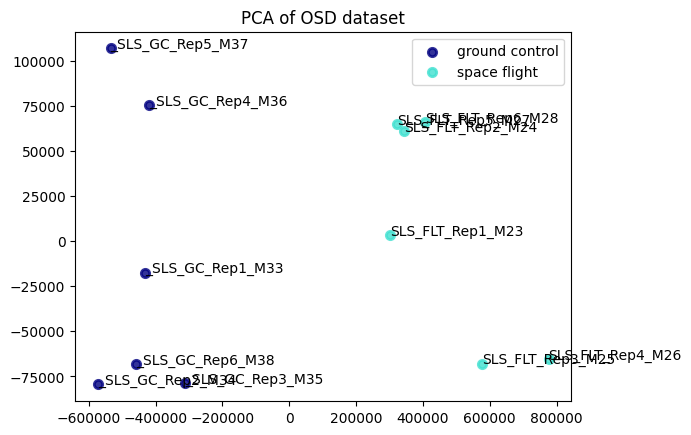

In [76]:
# call run_pca on expr_df_final
run_pca(expr_df, meta_df)

As you can tell, the sample gene expression profiles separate very cleanly in the plane. All the flight samples are on the right and all the ground samples are on the left. The first principal component (horizontal axis) accounts for 89% of the variation in the data. The second principal component (vertical axis) accounts for 6% of the variation in the data. If we were to plot this in 3 dimensions, the third principal component would account for some percentage of the variation less than 6%.

# Perform differential gene expression analysis

In [77]:
# First let's create a conditions table for 'Factor Value: Spaceflight'.
# We'll assign 0 for ground control and 1 for spaceflight
condition_dict=dict()
for sample in list(expr_df['sample']):
    val = meta_df[meta_df['Sample Name']==sample]['Factor Value[Spaceflight]'].values[0]
    if val.lower().strip() == 'ground control':
        condition_dict[sample] = 0
    elif val.lower().strip() == 'space flight':
        condition_dict[sample] = 1
    else:
      print('val ' + val + ' neither Ground Control nor Space Flight')
conditions =  pd.DataFrame.from_dict(condition_dict, orient='index')
conditions.columns = ['condition']


In [78]:
# examine conditions dataframe
for i in range(len(meta_df)):
  print(meta_df.iloc[i]['Sample Name'], meta_df.iloc[i]['Factor Value[Spaceflight]'], conditions.iloc[i]['condition'])

Mmus_C57-6J_SLS_GC_Rep1_M33 ground control 1
Mmus_C57-6J_SLS_GC_Rep2_M34 ground control 1
Mmus_C57-6J_SLS_GC_Rep3_M35 ground control 1
Mmus_C57-6J_SLS_GC_Rep4_M36 ground control 1
Mmus_C57-6J_SLS_GC_Rep5_M37 ground control 1
Mmus_C57-6J_SLS_GC_Rep6_M38 ground control 1
Mmus_C57-6J_SLS_FLT_Rep1_M23 space flight 0
Mmus_C57-6J_SLS_FLT_Rep2_M24 space flight 0
Mmus_C57-6J_SLS_FLT_Rep3_M25 space flight 0
Mmus_C57-6J_SLS_FLT_Rep4_M26 space flight 0
Mmus_C57-6J_SLS_FLT_Rep5_M27 space flight 0
Mmus_C57-6J_SLS_FLT_Rep6_M28 space flight 0


In [79]:
# make sure there are exactly 2 conditions for DGEA
set(meta_df['Factor Value[Spaceflight]'])


{'ground control', 'space flight'}

In [80]:
# create dataframe with 'sample' column removed for DESeq2
import numpy as np
counts = expr_df.drop(columns=['sample']).reset_index(drop=True)
# check for non-numeric
counts.applymap(np.isreal)
# convert all cells to integers
counts = counts.astype(int)
counts.shape

(12, 2104)

You can read more about the pyDeseq2 package in [this document](https://pydeseq2.readthedocs.io/en/stable/api/index.html#).

In [81]:
# run the DESEq2 experiment contrasting condition "0" (ground control) to condition "1" (space flight)
# store the results in a dataframe called "res"
dds = DeseqDataSet(counts=counts, metadata=conditions, design_factors="condition")
dds.deseq2()
stats_results = DeseqStats(dds, contrast = ('condition', 0, 1))
stats_results.summary()
res = stats_results.results_df

Using None as control genes, passed at DeseqDataSet initialization


/tmp/ipython-input-81-2785477244.py:3: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(counts=counts, metadata=conditions, design_factors="condition")
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 2.90 seconds.

Fitting dispersion trend curve...
/usr/local/lib/python3.11/dist-packages/pydeseq2/dds.py:807: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.05 seconds.

Fitting MAP dispersions...
... done in 3.26 seconds.

Fitting LFCs...
... done in 1.92 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: condition 0 vs 1
                     baseMean  log2FoldChange     lfcSE      stat  \
ENSMUSG00000000049  15.571456       -0.879139  0.489732 -1.795143   
ENSMUSG00000000167   8.375381        0.527831  0.580327  0.909541   
ENSMUSG00000000204   5.093550        0.120478  0.923265  0.130491   
ENSMUSG00000000214  13.560621       -0.330743  0.554538 -0.596431   
ENSMUSG00000000247  10.081343        0.167460  0.520320  0.321840   
...                       ...             ...       ...       ...   
ENSMUSG00000118232   4.506685        0.887308  0.685061  1.295226   
ENSMUSG00000118249   6.297331       -0.255434  0.567883 -0.449801   
ENSMUSG00000118292  14.765490       -1.221159  0.507039 -2.408413   
ENSMUSG00000118317  23.313326        2.126669  0.371385  5.726322   
ENSMUSG00000118353   3.805923        0.771506  0.689972  1.118170   

                          pvalue          padj  
ENSMUSG00000000049  7.263097e-02  2.329881e-01  
ENSMUSG00000000167

... done in 0.55 seconds.



In [82]:
# extract results of the DESeq2 experiment where  padj < 0.05, and log2fc > LOG2FC_THRESH
sigs = res[(res.padj < 0.05) & (abs(res.log2FoldChange) > LOG2FC_THRESH)]
print(sigs.shape)
sigs.head()

(159, 6)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSMUSG00000000308,4.820414,-2.448171,0.795020,-3.079382,2.074307e-03,1.691358e-02
ENSMUSG00000000567,1260.792252,2.013475,0.358486,5.616615,1.947351e-08,7.262898e-07
ENSMUSG00000001510,6.460441,-3.883514,1.381168,-2.811761,4.927107e-03,3.386755e-02
ENSMUSG00000002910,1148.829888,-2.055559,0.334742,-6.140728,8.214411e-10,5.704767e-08
ENSMUSG00000006576,786.372675,2.003514,0.264344,7.579201,3.476886e-14,1.167075e-11


In [83]:
# write differentially expressed gene list to file
deg_genes = list(sigs.index)
with open(f"{DGEA_DIR}/deg_genes-" + OSD_DATASET + ".txt", "w") as f:
  for gene in deg_genes:
    f.write(gene + "\n")
f.close()

# check gene file
!head {DGEA_DIR}/deg_genes-{OSD_DATASET}.txt

ENSMUSG00000000308
ENSMUSG00000000567
ENSMUSG00000001510
ENSMUSG00000002910
ENSMUSG00000006576
ENSMUSG00000015090
ENSMUSG00000015401
ENSMUSG00000015599
ENSMUSG00000016179
ENSMUSG00000018486


In [84]:
# write list of background genes to file
bg_genes = list(expr_df.drop(columns=['sample']))
with open(f"{DGEA_DIR}/background_genes-" + OSD_DATASET + ".txt", "w") as f:
  for gene in bg_genes:
    f.write(gene + "\n")
f.close()

# check gene file
!head {DGEA_DIR}/background_genes-{OSD_DATASET}.txt

ENSMUSG00000000049
ENSMUSG00000000167
ENSMUSG00000000204
ENSMUSG00000000214
ENSMUSG00000000247
ENSMUSG00000000303
ENSMUSG00000000308
ENSMUSG00000000385
ENSMUSG00000000386
ENSMUSG00000000409


# Create volcano plot

You can learn more about how this volcano plot was generated reading [this article](https://bioinformatics.ccr.cancer.gov/docs/pies-2023/pies_lesson4/).

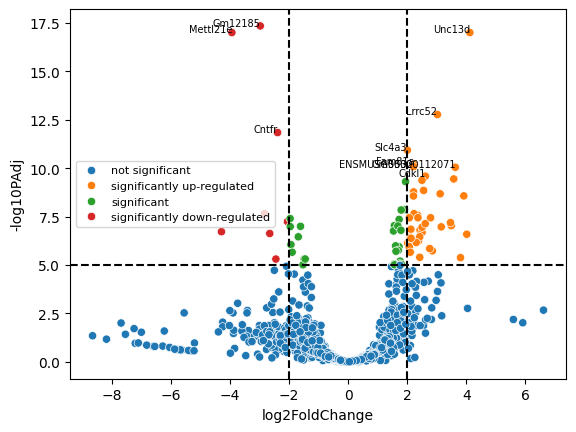

In [85]:
# import Python modules for plotting volcano
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn

# create column for -log10PAdj from existing padj
res['-log10PAdj'] = -numpy.log10(res['padj'])

# create column for significance from existing log2FoldChange and -log10PAdj
significance = []
for i in range(len(res)):
    if res.iloc[i]['log2FoldChange'] > LOG2FC_THRESH and res.iloc[i]['-log10PAdj'] > 5:
        significance.append('significantly up-regulated')
    elif res.iloc[i]['log2FoldChange'] < -LOG2FC_THRESH and res.iloc[i]['-log10PAdj'] > 5:
        significance.append('significantly down-regulated')
    elif res.iloc[i]['-log10PAdj'] > 5 and res.iloc[i]['padj'] < 0.05:
        significance.append('significant')
    else:
        significance.append('not significant')

res['significance'] = significance
# plot the degs
plot1 = seaborn.scatterplot(res, x = "log2FoldChange", y = "-log10PAdj", hue = "significance")

# sort to get top 10 significant genes
top10 = sigs[sigs['padj'] < 0.05].sort_values(by=['padj', 'log2FoldChange'], ascending=[True, False]).head(10)

# add gene_symbol to top10
gene_symbol_list = get_symbol_from_id(list(top10.index))
top10['gene_symbol'] = gene_symbol_list

# add -log10PAdj to top10
top10['-log10PAdj'] = -numpy.log10(top10['padj'])

# annotate top 10 significant genes
for i in range(top10.shape[0]):
    gene = top10.iloc[i]
    plt.text(gene['log2FoldChange'], gene['-log10PAdj'], gene['gene_symbol'], fontsize=7, ha='right')

# draw a line at y=5 for significance
plt.axhline(y = 5, color='black', linestyle='--')

# draw 2 lines at fold change threshold
plt.axvline(x = LOG2FC_THRESH, color = 'black', linestyle='--')
plt.axvline(x = -LOG2FC_THRESH, color='black', linestyle='--')

# set font size for legend
plt.legend(fontsize=8)


In [86]:
sigs

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSMUSG00000000308,4.820414,-2.448171,0.795020,-3.079382,2.074307e-03,1.691358e-02
ENSMUSG00000000567,1260.792252,2.013475,0.358486,5.616615,1.947351e-08,7.262898e-07
ENSMUSG00000001510,6.460441,-3.883514,1.381168,-2.811761,4.927107e-03,3.386755e-02
ENSMUSG00000002910,1148.829888,-2.055559,0.334742,-6.140728,8.214411e-10,5.704767e-08
ENSMUSG00000006576,786.372675,2.003514,0.264344,7.579201,3.476886e-14,1.167075e-11
...,...,...,...,...,...,...
ENSMUSG00000116597,5.501568,-2.471409,0.763147,-3.238444,1.201838e-03,1.131075e-02
ENSMUSG00000116725,16.483220,3.150681,0.524991,6.001405,1.956177e-09,1.064795e-07
ENSMUSG00000116851,47.623784,-2.088961,0.413996,-5.045846,4.515181e-07,1.151085e-05
ENSMUSG00000117313,29.324407,-2.022712,0.416676,-4.854405,1.207486e-06,2.861032e-05


The horizontal line (y=5) represents the negative log of the adjusted p-value (-log10PAdj). The value -log10(5), or 0.05, is the standard alpha level of significance for most scientific research. You can read more about the alpha level of significance [here](https://en.wikipedia.org/wiki/Statistical_significance).

The two vertical lines (x=-LOG2FC_THRESH and x=+LOG2FC_THRESH) represent the number of times up- and down-regulated the gene expression value is between the 2 conditions of spaceflight and ground control, respectively. We defined the LOG2FC_THRESH value at the top of this notebook. You can read more about the log2 fold-change threshold for DGEA [here](https://www.biostars.org/p/9505003/).

The list of differentially expressed genes include those which are significantly down-regulated (in green) and significantly up-regulated (in red).

# Check your work before moving on

In [87]:
# make sure your google drive disk space utilization is still under 15G
# should be about 2.4GB
!du -sh /content/mnt/MyDrive/NASA/GL4HS

2.4G	/content/mnt/MyDrive/NASA/GL4HS


In [88]:
# time the notebook
import datetime
end_time = datetime.datetime.now()
print('notebook end time: ', end_time.strftime('%Y-%m-%d %H:%M:%S'))

print('notebook runtime: ', end_time - start_time)
#

notebook end time:  2025-07-16 04:22:37
notebook runtime:  0:01:13.568220
